Submit your regression result for the following kaggle dataset. https://www.kaggle.com/harlfoxem/housesalesprediction/kernels

In [3]:
# Loading requird libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import xgboost
import math
from __future__ import division
from scipy.stats import pearsonr
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)

from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

# EDA

In [4]:
data=pd.read_csv('kc_house_data.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [6]:
# data understanding
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


In [7]:
# Check the number of data points in the data set
print(len(data))
# Check the number of features in the data set
print(len(data.columns))
# Check the data types
print(data.dtypes.unique())

21613
21
[dtype('int64') dtype('O') dtype('float64')]


In [9]:
# Check any number of columns with NaN
print(data.isnull().any().sum(), ' / ', len(data.columns))
# Check any number of data points with NaN
print(data.isnull().any(axis=1).sum(), ' / ', len(data))

0  /  21
0  /  21613



## Finding correlations between the features and the target variable

In [10]:
features = data.iloc[:,3:].columns.tolist()
target = data.iloc[:,2].name

In [11]:
correlations = {}
for f in features:
    data_temp = data[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]

In [12]:
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
sqft_living vs price,0.702035
grade vs price,0.667434
sqft_above vs price,0.605567
sqft_living15 vs price,0.585379
bathrooms vs price,0.525138
view vs price,0.397293
sqft_basement vs price,0.323816
bedrooms vs price,0.308350
lat vs price,0.307003
waterfront vs price,0.266369


In [13]:

#We can see that the top 5 features are the most correlated features with the target "price" Let's plot the best 2 regressors jointly
y = data.loc[:,['sqft_living','grade',target]].sort_values(target, ascending=True).values
x = np.arange(y.shape[0])

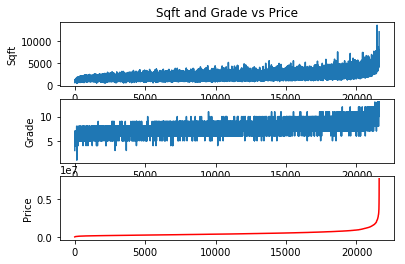

In [14]:
%matplotlib inline
plt.subplot(3,1,1)
plt.plot(x,y[:,0])
plt.title('Sqft and Grade vs Price')
plt.ylabel('Sqft')

plt.subplot(3,1,2)
plt.plot(x,y[:,1])
plt.ylabel('Grade')

plt.subplot(3,1,3)
plt.plot(x,y[:,2],'r')
plt.ylabel("Price")

plt.show()

C:\Users\nn\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
C:\Users\nn\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\nn\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\nn\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nn\Anaconda3\lib\site-packages\statsmodels\nonparametric\bandwidths.py:20: RuntimeWarning

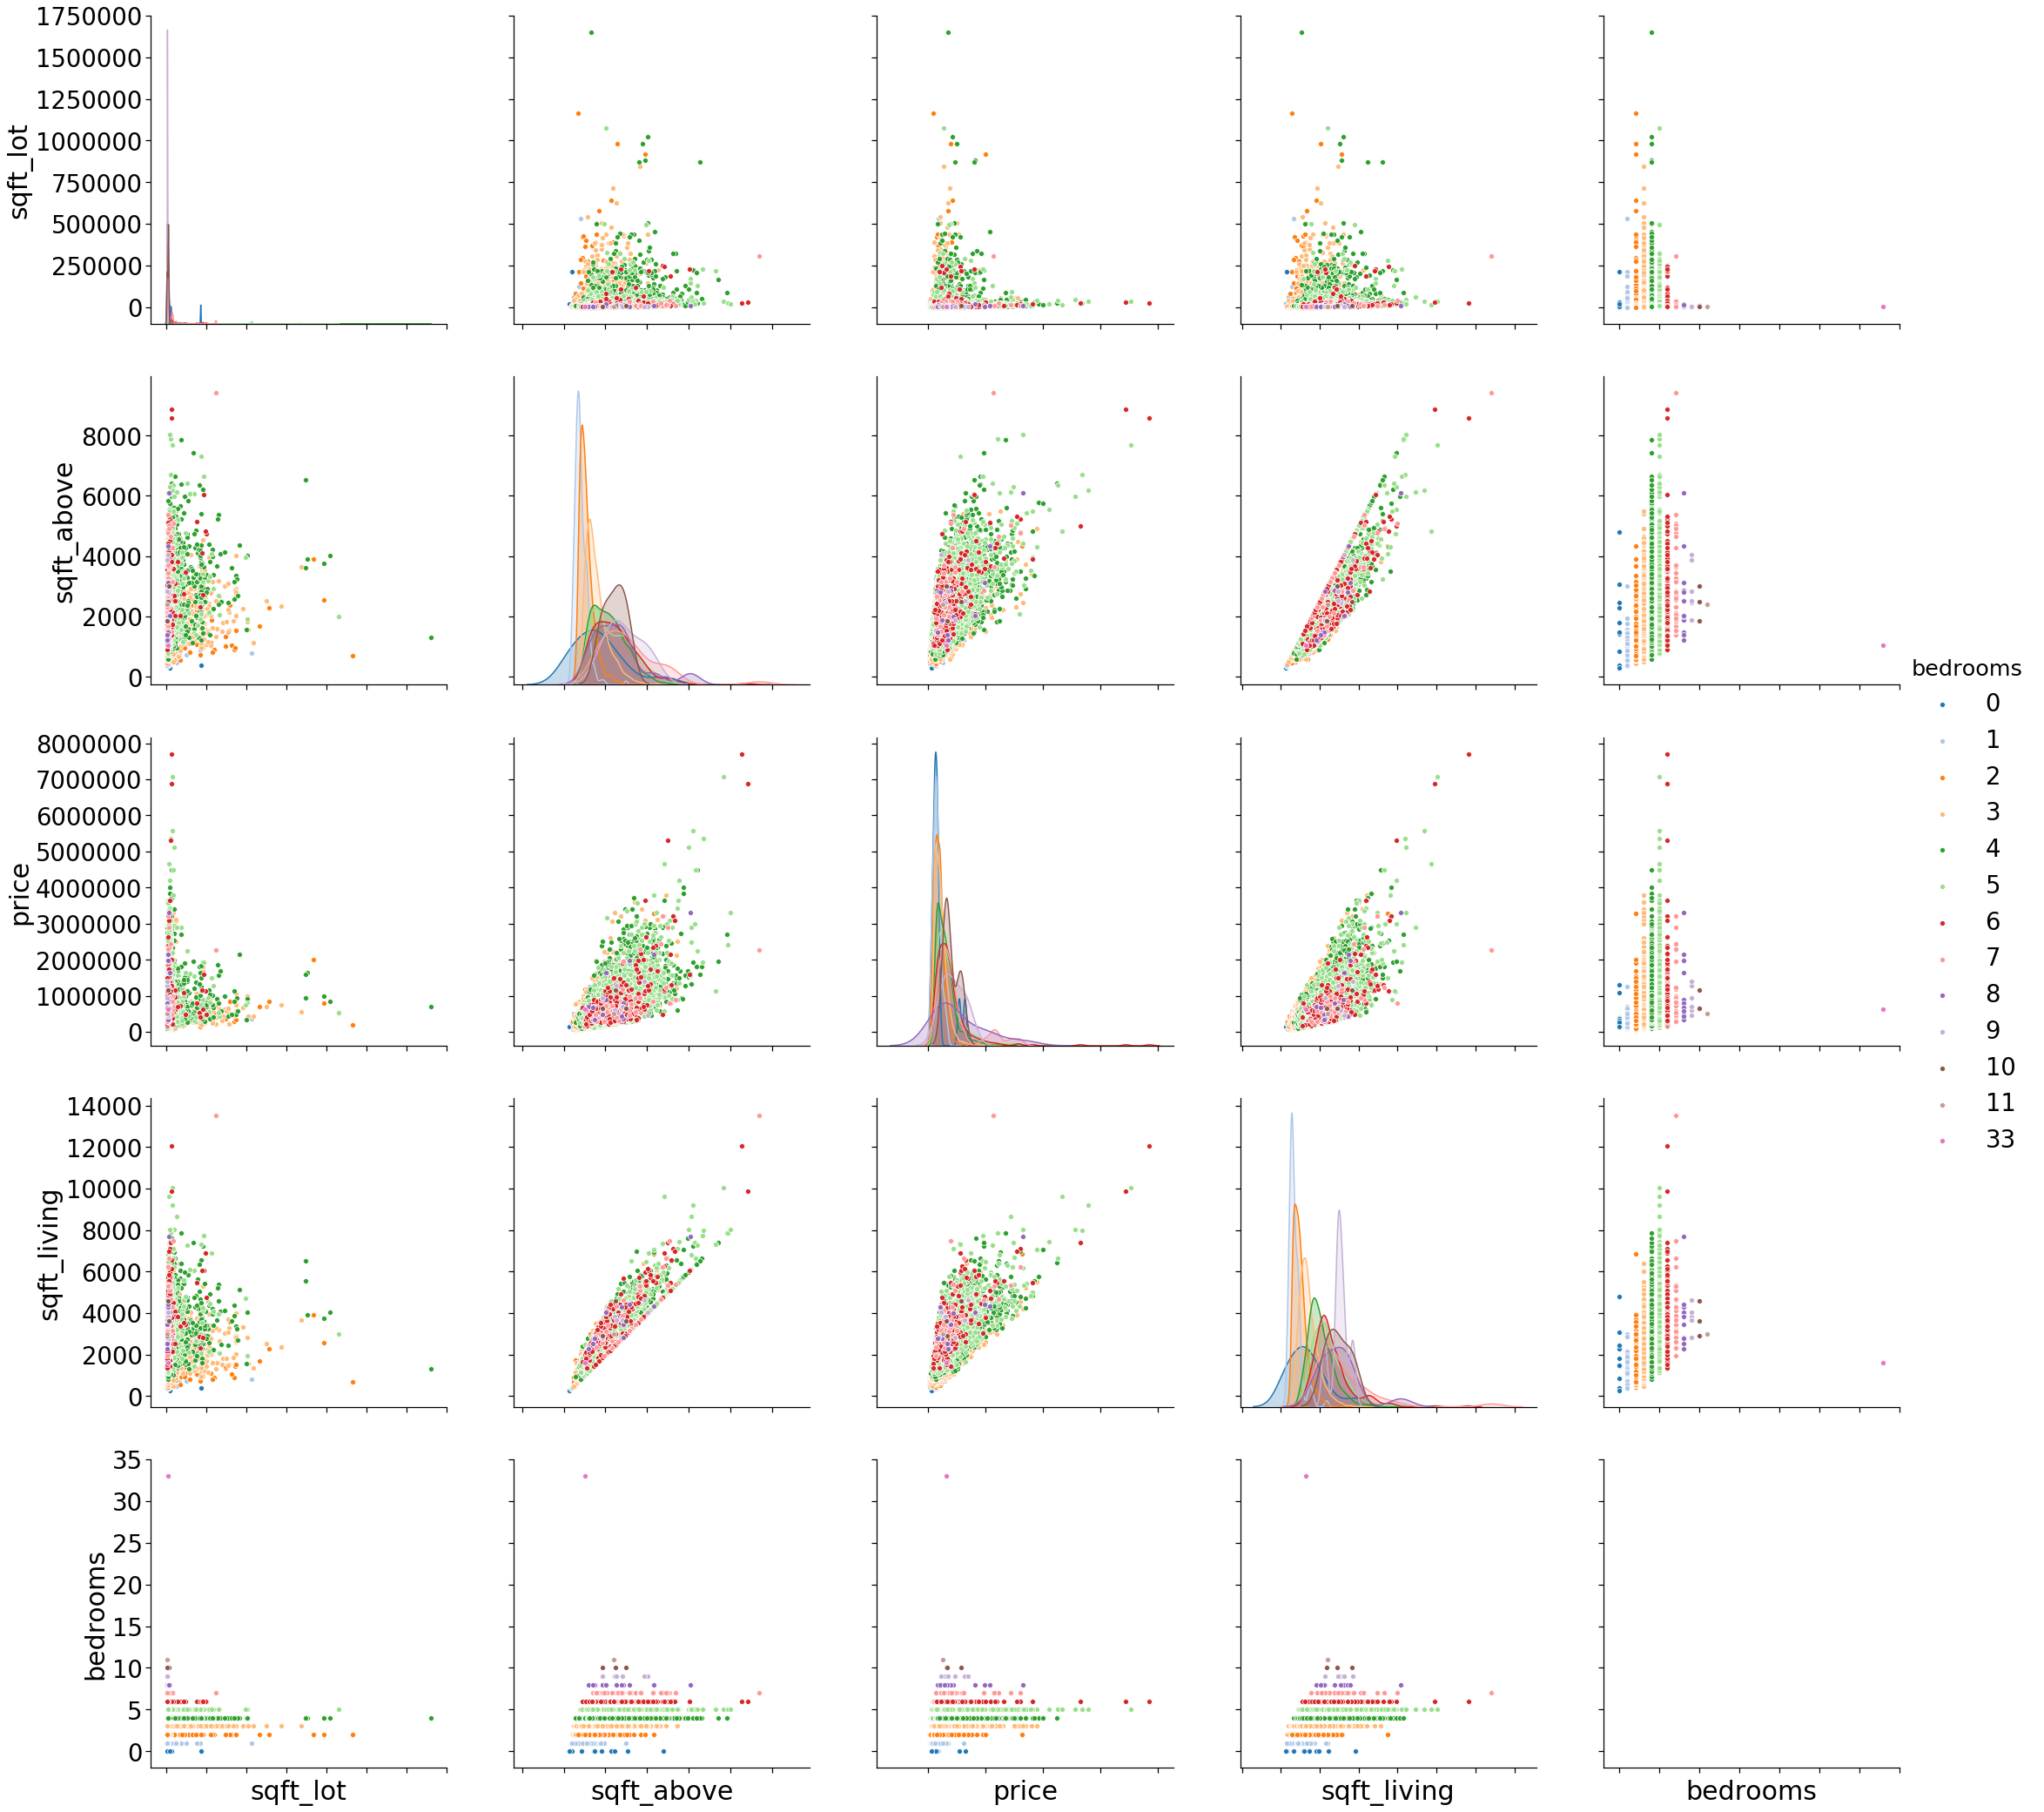

In [15]:
with sns.plotting_context("notebook",font_scale=2.5):
    g = sns.pairplot(data[['sqft_lot','sqft_above','price','sqft_living','bedrooms']], 
                 hue='bedrooms', palette='tab20',size=6)
g.set(xticklabels=[]);

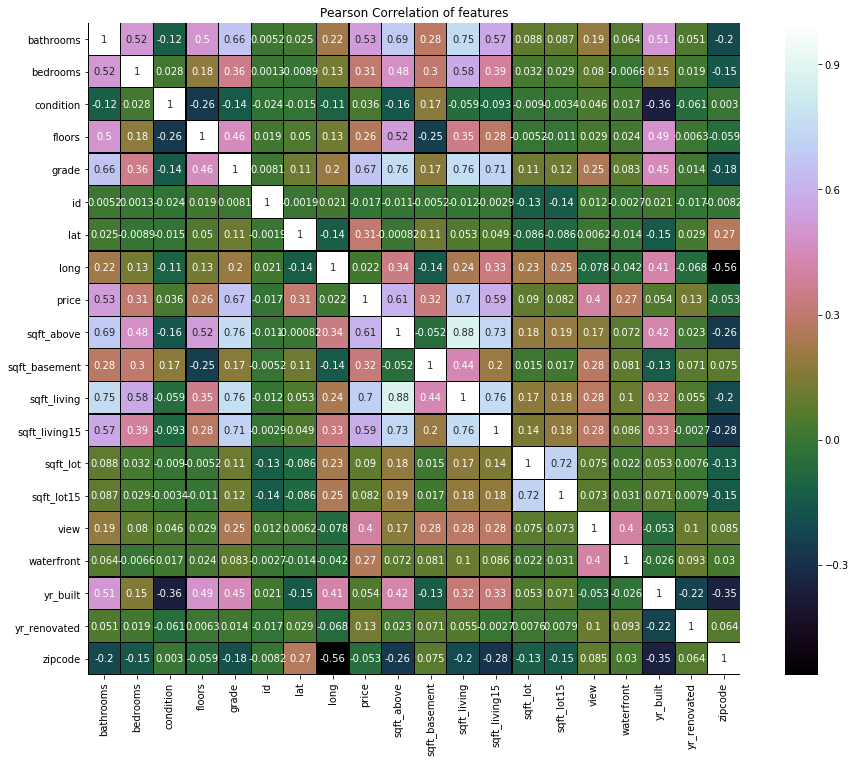

In [16]:
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in data.iteritems():
    if type(colvalue[1]) == str:
         str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = data.columns.difference(str_list) 
# Create Dataframe containing only numerical features
data_num = data[num_list]
f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation of features')
# Draw the heatmap using seaborn
#sns.heatmap(house_num.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="PuBuGn", linecolor='k', annot=True)
sns.heatmap(data_num.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="cubehelix", linecolor='k', annot=True)

## Predicting House Sales Prices

In [21]:
# Train a simple linear regression model
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
regr = linear_model.LinearRegression()
new_data = data[['sqft_living','grade', 'sqft_above', 'sqft_living15','bathrooms','view','sqft_basement',
                 'lat','waterfront','yr_built','bedrooms']]

In [22]:

# Dependent and independent values are loading into X and Y
X = new_data.values
y = data.price.values

In [45]:
# Tarin and Test data Split

from sklearn.model_selection import train_test_split
# Tarin and Test data Split
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2)

In [46]:
# Fitting the train values and predicting the test
regr.fit(X_train, y_train)

print(regr.predict(X_test))

[ 236843.2657697  1179897.9648318   389103.37056175 ...  695253.72426916
  532153.84463485  266772.57495859]


In [47]:
# Regression Score of Linear regression model
regr.score(X_test,y_test)

0.706222388281785

In [48]:
# Calculate the Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((regr.predict(X_test) - y_test) ** 2)))

RMSE: 193917.69


In [49]:

#Lets try with othermodel like XG boost

xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [50]:
traindf, testdf = train_test_split(X_train, test_size = 0.3)
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.08, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.75)

In [51]:
predictions = xgb.predict(X_test)
print(explained_variance_score(predictions,y_test))

0.8342257219087144
